In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hpvsim as hpv
import time as t 
import random as rn
import math as m 
import seaborn as sb
import matplotlib.cm as cm
import ast
import matplotlib.patches as patches

## Colors for graphs

In [15]:
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, 3)]

In [16]:
#-------------------------------------------------------------
# Simulation parameters
#-------------------------------------------------------------
n_agents = 50000 # Anas analysis
location = 'tunisia' 
start = 1990 # calibration reasons
end = 2090 
burnin = 20
dt = 0.25
network = 'default'

#-------------------------------------------------------------
# Initialization parameters
#-------------------------------------------------------------
init_hpv_prev = {
                'age_brackets': [30, 40, 50, 150], 
                'm': [0.124, 0.07, 0.064, 0.081], 
                'f': [0.124, 0.07, 0.064, 0.081]
                }
init_hpv_dist = {
                'hpv31': 0.019,
                'hpv16': 0.011,
                'hpv59': 0.0125,
                'hpv52': 0.012,
                'hpv18': 0.011,
                'hpv35': 0.0055,
                'hpv58': 0.0065,
                'hpv56': 0.0045,
                'hpv39': 0.0045, 
                'lr': 0.9135
                }

#-------------------------------------------------------------
# Sexual Behavior parameters
#-------------------------------------------------------------
cross_layer_options = [
    dict(
        f=0.05, # default value in HPVsim
        m=0.3, # default value in HPVsim
    ),
    dict(
        f=0.1, # calibration
        m=0.25, # calibration
    ),
]
cross_layer_option = cross_layer_options[1]  # change here for cross-layer mixing choice (0: default, 1: results of calibration for Tunisia)

f_cross_layer = cross_layer_option['f']
m_cross_layer = cross_layer_option['m']

debut = dict( 
    f = dict(dist='normal', par1=23, par2=3), # source: GTBC + INS
    m = dict(dist='normal', par1=22, par2=4),
)

dur_pship_options = [
    dict(
            m=dict(dist='neg_binomial', par1=80, par2=3), # Default. This gives: mar_dur = {'0-5y': 0.015, '5-10y': 0.025, '10-20y':0.06, '20-50y':0.25, '50+':0.65}
            c=dict(dist='lognormal', par1=1, par2=2), # Default. This gives: cas_dur = {'0-3m': 0.33, '3-6m': 0.22, '6-12m': 0.2, '1-2y':0.15, '2-5y':0.1}
    ),
    dict( 
            m=dict(dist='lognormal', par1=20, par2=26), # lognormal that best fits denmark stats. see: https://docs.google.com/document/d/1YC2rJHEpL49zbXuuwsTw0sqj4KXQMfCj92KmUTcM1Xs/edit?usp=sharing
            c=dict(dist='lognormal', par1=1, par2=2), # Default. This gives: cas_dur = {'0-3m': 0.33, '3-6m': 0.22, '6-12m': 0.2, '1-2y':0.15, '2-5y':0.1}
    ),
]
dur_pship = dur_pship_options[1]  # change here for duration of partnership choice (0: default, 1: our assumption for Tunisia)

#defaults (do not change)
m_partners = dict(
    m=dict(dist='poisson1', par1=0.01), # Everyone in this layer has one marital partner; this captures *additional* marital partners. If using a poisson distribution, par1 is roughly equal to the proportion of people with >1 spouse
    c=dict(dist='poisson1', par1=0.5)
) # If using a poisson distribution, par1 is roughly equal to the proportion of people with >1 casual partner within a single time step

f_partners = dict(
    m=dict(dist="poisson1", par1=0.01),
    c=dict(dist='poisson', par1=1), # Defaults: {'0': 0.36, '1': 0.37, '2': 0.19, '3': 0.06, '4+':0.02}
)

layer_probs_options = [
    dict( #all default
            m=np.array([
                [ 0,  5,    10,    15,   20,   25,   30,   35,    40,    45,    50,   55,   60,   65,   70,   75],
                [ 0,  0,  0.01,   0.5,  0.5,  0.5,  0.5,  0.5,   0.5,   0.5,   0.5,  0.3,  0.2,  0.1, 0.05, 0.01], # Share of females of each age who are actively seeking marriage if underpartnered
                [ 0,  0,  0.01,   0.2,  0.3,  0.5,  0.5,  0.5,   0.5,   0.5,   0.5,  0.3,  0.2,  0.1, 0.05, 0.01]] # Share of males of each age who are actively seeking marriage if underpartnered
            ),
            c=np.array([
                [ 0,  5,    10,    15,   20,   25,   30,   35,    40,    45,    50,   55,   60,   65,   70,   75],
                [ 0,  0,   0.2,   0.6,  0.8,  0.6,  0.4,  0.4,   0.4,   0.1,  0.02, 0.02, 0.02, 0.02, 0.02, 0.02], # Share of females of each age actively seeking casual relationships if underpartnered
                [ 0,  0,   0.2,   0.4,  0.4,  0.4,  0.4,  0.6,   0.8,   0.6,   0.2,  0.1, 0.05, 0.02, 0.02, 0.02]] # Share of males of each age actively seeking casual relationships if underpartnered
            )
    ),
    dict(   # marital INS, casual default
        m=np.array([  # source: https://books.openedition.org/ined/18618?lang=en     
            [ 0,  5,    10,    15,   20,   25,   30,   35,    40,    45,    50,   55,   60,   65,   70,   75],
            [ 0,  0,  0.01,   0.1,  0.4,  0.7,  0.8,  0.7,   0.7,   0.6,   0.6,  0.3,  0.2,  0.1, 0.05, 0.01], # Females actively seeking marriage if underpartnered
            [ 0,  0,  0.01,   0.05,  0.1,  0.5,  0.5,  0.8,   0.8,   0.8,   0.7,  0.4,  0.2,  0.1, 0.05, 0.01]] # Males actively seeking marriage if underpartnered
        ),
        c=np.array([
                [ 0,  5,    10,    15,   20,   25,   30,   35,    40,    45,    50,   55,   60,   65,   70,   75],
                [ 0,  0,   0.2,   0.6,  0.8,  0.6,  0.4,  0.4,   0.4,   0.1,  0.02, 0.02, 0.02, 0.02, 0.02, 0.02], # Share of females of each age actively seeking casual relationships if underpartnered
                [ 0,  0,   0.2,   0.4,  0.4,  0.4,  0.4,  0.6,   0.8,   0.6,   0.2,  0.1, 0.05, 0.02, 0.02, 0.02]] # Share of males of each age actively seeking casual relationships if underpartnered
            )
    ),
]
layer_probs = layer_probs_options[1]  # change here. 0: all default; 1: marital according INS and casual default; 

mixing_options = [
    np.array([  # source INS
        #       0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75   [F]
        [ 0,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 5,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [10,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [15,    0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [20,    0,  0,  0,  0, .1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [25,    0,  0,  0, .4, .7, .4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [30,    0,  0,  0,  1,  1,  1, .5, .1,  0,  0,  0,  0,  0,  0,  0,  0],
        [35,    0,  0,  0,  0, .6, .9,  1, .5, .1,  0,  0,  0,  0,  0,  0,  0],
        [40,    0,  0,  0, .2, .1, .3, .7,  1, .7, .1,  0,  0,  0,  0,  0,  0],
        [45,    0,  0,  0,  0,  0, .1, .3, .7,  1, .5, .1,  0,  0,  0,  0,  0],
        [50,    0,  0,  0,  0,  0,  0, .1, .2, .7,  1, .5, .1,  0,  0,  0,  0],
        [55,    0,  0,  0,  0,  0,  0,  0, .1, .2, .6,  1, .5, .1,  0,  0,  0],
        [60,    0,  0,  0,  0,  0,  0,  0,  0, .1, .2, .6,  1, .5, .1,  0,  0], 
        [65,    0,  0,  0,  0,  0,  0,  0,  0,  0, .1, .2, .6,  1, .5, .1,  0], 
        [70,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, .2, .6,  1, .5, .1],  
        [75,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, .2, .6,  1,  1],
]),
    np.array([
        #       0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75  [F]
        [ 0,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 5,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [10,    0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [15,    0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [20,    0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [25,    0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [30,    0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [35,    0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
        [40,    0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
        [45,    0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
        [50,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
        [55,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
        [60,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
        [65,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
        [70,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
        [75,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
]),
]
mixing_option = mixing_options[0]  # change here for mixing matrix choice (0: Tunisian from INS marital data, 1: Diagonal)
mixing = dict()
mixing['m'] = mixing_option
mixing['c'] = np.array([
            #       0,  5,  10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75
            [ 0,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
            [ 5,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
            [10,    0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
            [15,    0,  0,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
            [20,    0,  0,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
            [25,    0,  0, .5,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0],
            [30,    0,  0,  0, .5,  1,  1,  1, .5,  0,  0,  0,  0,  0,  0,  0,  0],
            [35,    0,  0,  0, .5,  1,  1,  1,  1, .5,  0,  0,  0,  0,  0,  0,  0],
            [40,    0,  0,  0,  0, .5,  1,  1,  1,  1, .5,  0,  0,  0,  0,  0,  0],
            [45,    0,  0,  0,  0,  0,  1,  1,  1,  1,  1, .5,  0,  0,  0,  0,  0],
            [50,    0,  0,  0,  0,  0, .5,  1,  1,  1,  1,  1, .5,  0,  0,  0,  0],
            [55,    0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1, .5,  0,  0,  0],
            [60,    0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1, .5,  0,  0],
            [65,    0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1, .5,  0],
            [70,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1, .5],
            [75,    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1],
        ])


#-------------------------------------------------------------
# Infection / Transmission parameters
#-------------------------------------------------------------

condoms = dict(
    m = 0.01, #default
    c = 0.18 # source GTBC
)
beta = 0.13 # calibration
transm2f = 3 # calibration
transf2m = 1 # calibration
eff_condoms = 0.7 #  https://www.nejm.org/doi/10.1056/NEJMoa053284?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200www.ncbi.nlm.nih.gov


#-------------------------------------------------------------
# Intervention parameters
#-------------------------------------------------------------
pap_test = hpv.routine_screening(
    product='pap',
    prob=0.01,
    age_range=[35, 60],
    start_year=2010,
    label='pap primary',
)
    
to_colposcopy = lambda sim: sim.get_intervention('pap primary').outcomes['abnormal']
colposcopy_test = hpv.routine_triage(
                product='colposcopy',
                prob = 0.9,
                eligibility=to_colposcopy,
                label = 'colposcopy secondary'
            )
        
    
hsils = lambda sim: sim.get_intervention('colposcopy secondary').outcomes['hsil']
excision = hpv.treat_num(
                prob = 0.9,
                product = 'excision',
                eligibility = hsils,
                label = 'excision'
            )
        
lsils = lambda sim: sim.get_intervention('colposcopy secondary').outcomes['lsil']
ablation = hpv.treat_num(
                prob = 0.9,
                product = 'ablation',
                eligibility = lsils,
                label = 'ablation'
            )

tn_interventions = [pap_test, colposcopy_test, ablation, excision]

#-------------------------------------------------------------
# Genotypess
#-------------------------------------------------------------
genotypes = ['hpv31', 'hpv16', 'hpv59', 'hpv52', 'hpv18', 'hpv35', 'hpv58', 'hpv56', 'hpv39', 'lr']      
n_genotypes =  10

#-------------------------------------------------------------
#-------------------------------------------------------------
#-------------------------------------------------------------
tn_parameters= dict(
    n_agents = n_agents,
    location = location,
    dt = dt,
    network = network,
    start = start,
    end = end,
    burnin = burnin,
    debut = debut,
    m_partners = m_partners,
    f_partners = f_partners, 
    dur_pship = dur_pship,
    f_cross_layer = f_cross_layer,
    m_cross_layer = m_cross_layer,
    layer_probs = layer_probs,
    mixing = mixing,
    condoms = condoms,
    beta = beta,
    transm2f = transm2f,
    transf2m = transf2m,
    eff_condoms = eff_condoms,
    genotypes = genotypes,
    n_genotypes = n_genotypes,
    ms_agent_ratio = 1,
    rel_birth = 1,
    rel_death = 1,
    sex_ratio = 0.5,
    rel_init_prev =1,
    rand_seed = 1,
    verbose = 0.25,
    use_migration = False,
    init_hpv_prev = init_hpv_prev,
    init_hpv_dist = init_hpv_dist,
)


## Simulating Baseline

In [17]:
n=10
sim = hpv.Sim(tn_parameters, interventions=tn_interventions)
msim = hpv.MultiSim(sim)
msim.run(n_runs=n)
msim.mean()

Loading location-specific demographic data for "tunisia"


## visualizing HPV genotype distribution

In [18]:
def average_error(list1, list2):
    total_error = 0
    n = len(list1)
    for i in range(n):
        total_error += abs(list1[i] - list2[i])
    return total_error / n


from sklearn.metrics import r2_score

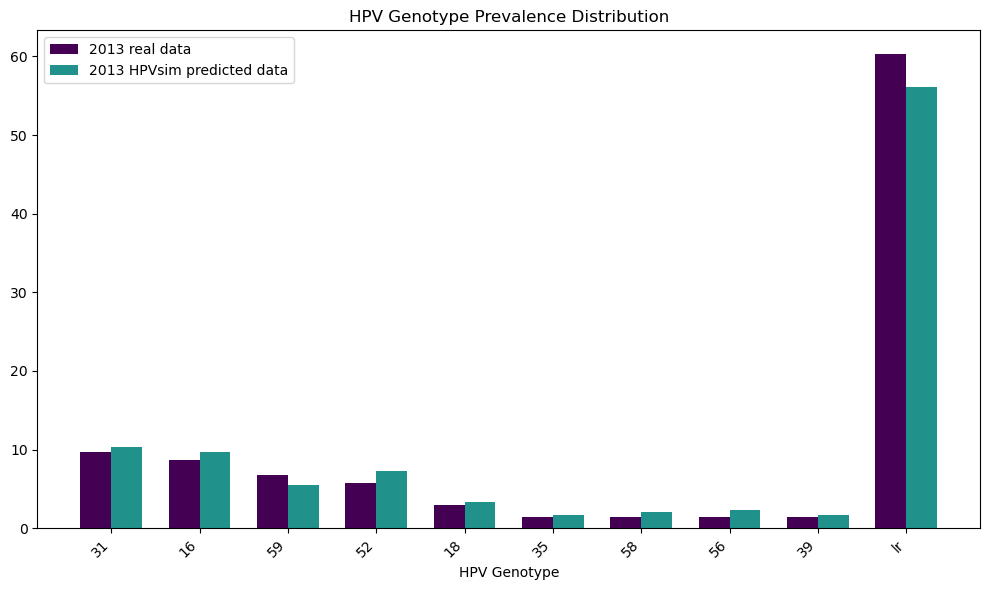

Average error in 2013: 1.1112501132425088
R2 score in 2013: 0.9914872980981391


In [19]:
from sklearn.metrics import r2_score

yearly_genotypes = msim.results['infections_by_genotype'][0:]
yearly_infections = msim.results['infections'][0:]

checkpoint_per_genotype = yearly_genotypes[:, 23]
checkpoint_total = yearly_infections[23]

for i in range(len(checkpoint_per_genotype)):
    checkpoint_per_genotype[i] = checkpoint_per_genotype[i]/checkpoint_total

target = [
        0.097,
        0.087,
        0.068,
        0.058,
        0.029,
        0.0145,
        0.0145,
        0.0145,
        0.0145, 
        0.603
    ]

names = ['31', '16', '59', '52', '18', '35', '58', '56', '39', 'lr']

total_2013_real = sum(target)
percentages_2013_real = [100 * (count / total_2013_real) for count in target]

total_2013_sim = sum(checkpoint_per_genotype)
percentages_2013_sim = [100 * (count / total_2013_sim) for count in checkpoint_per_genotype]

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(10)
plt.bar(index, percentages_2013_real, label='2013 real data', color=colors[0], width=bar_width)
plt.bar(index + bar_width, percentages_2013_sim, label='2013 HPVsim predicted data', color=colors[1], width=bar_width)
plt.title('HPV Genotype Prevalence Distribution')
plt.xlabel('HPV Genotype')
plt.xticks(index + bar_width / 2, names, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

error_2013 = average_error(percentages_2013_real, percentages_2013_sim)
r2_2013 = r2_score(percentages_2013_real, percentages_2013_sim)

print("Average error in 2013:", error_2013)
print("R2 score in 2013:", r2_2013)


## Visualzing annual cancer cases 2021-2024

[342. 378. 414.]


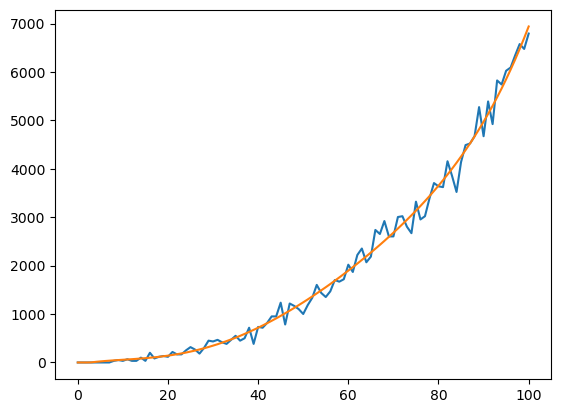

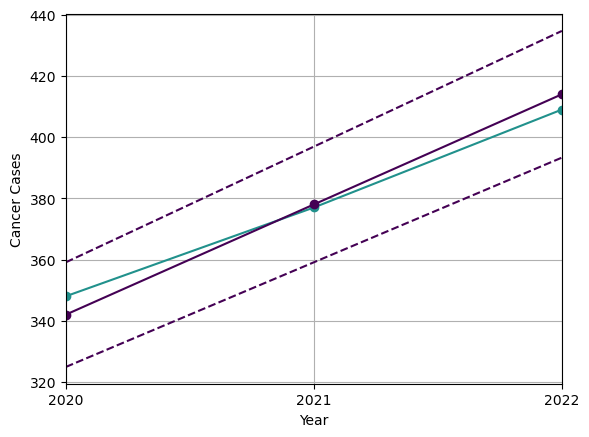

In [20]:
x = msim.results['year']

true = np.linspace(342, 414, 3) #2020-2022
true_up = [t*1.05 for t in true]
true_down = [t*0.95 for t in true]

print(true)

deaths = msim.results['cancer_deaths']
cancers = msim.results['cancers']
infections = msim.results['infections']

yearly_infections = infections
yearly_infections = [round(x) for x in yearly_infections]
coefficients = np.polyfit(x[:], yearly_infections, 5) 
yearly_infections_fitted = np.polyval(coefficients, x[:])
yearly_infections_fitted = [round(x) for x in yearly_infections_fitted]
yearly_infections_fitted = [0 if x < 0 else x for x in yearly_infections_fitted]

yearly_cancers = cancers
yearly_cancers = [round(x) for x in yearly_cancers]
coefficients = np.polyfit(x[:], yearly_cancers, 5) 
yearly_cancers_fitted = np.polyval(coefficients, x[:])
yearly_cancers_fitted = [round(x) for x in yearly_cancers_fitted]
yearly_cancers_fitted = [0 if x < 0 else x for x in yearly_cancers_fitted]

yearly_deaths = deaths
yearly_deaths = [round(x) for x in yearly_deaths]
coefficients = np.polyfit(x[:], yearly_deaths, 5) 
yearly_deaths_fitted = np.polyval(coefficients, x[:])
yearly_deaths_fitted = [round(x) for x in yearly_deaths_fitted]
yearly_deaths_fitted = [0 if x < 0 else x for x in yearly_deaths_fitted]

plt.plot(cancers)
plt.plot(yearly_cancers_fitted)
plt.show()

plt.plot(x[30:30+3], yearly_cancers_fitted[30:30+3],  marker='o', color=colors[1], label='HPVsim predictions')
plt.plot(x[30:30+3], true , color = colors[0],  marker='o', label = 'National predictions')
plt.plot(x[30:30+3], true_up , color = colors[0], linestyle='--', label = '10% error margin')
plt.plot(x[30:30+3], true_down , color = colors[0], linestyle='--')
plt.xlabel('Year')
plt.ylabel('Cancer Cases')
plt.xlim(2020, 2022)
plt.xticks([2020, 2021, 2022])
plt.grid(True)
plt.show()
